*Example use of xarray/dask/xgcm with GIGATL1 extractions:*

## Various operations on 3D CROCO files

- Interpolation to horizontal grids
- Computation of derivaties (relative vorticity)
- Plotting vertical section
- Interpolation on a geopotential level
- Compute and plot density

#########################

Examples adapted from https://github.com/slgentil/croco/blob/master/tutorials/xgcm.ipynb

#########################

In [1]:
%load_ext memory_profiler

import xarray as xr
import numpy as np

#import xroms
from xgcm import Grid

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('lat','lat').replace('lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        
    '''    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])
    '''

    return ds

###################################

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    
###################################


def dll_dist(dlon, dlat, lon, lat):
    """
    Converts lat/lon differentials into distances in meters
    
    parameters:
        dlon : xarray.DataArray longitude differentials 
        dlat : xarray.DataArray latitude differentials 
        lon : xarray.DataArray longitude values
        lat : xarray.DataArray latitude values
    returns:
        dx : xarray.DataArray distance inferred from dlon 
        dy : xarray.DataArray distance inferred from dlat 
    """
    
    distance_1deg_equator = 111000.0
    dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator 
    dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
    return dx, dy

###################################

def add_vertical_coord(ds):
    
    if ds.VertCoordType=='NEW':
        ds['Vtransform'] = 2
    else:
        ds['Vtransform'] = 1

    #####################
    
    ds['sc_r'] = xr.DataArray(ds.sc_r,  dims=["s_rho"])
    ds['sc_w'] = xr.DataArray(ds.sc_w,  dims=["s_w"])
    ds['Cs_r'] = xr.DataArray(ds.Cs_r,  dims=["s_rho"])
    ds['Cs_w'] = xr.DataArray(ds.Cs_w,  dims=["s_w"])

    #####################
    # Including vertical coordinates

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.sc_r - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.sc_r + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho; del Zo_rho

    ds.coords['z_rho'] = z_rho  * ds.mask_rho

    if ds.Vtransform == 1:
        Zo_w = ds.hc * (ds.sc_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_rho + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_w = (ds.hc * ds.sc_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w; del Zo_w

    ds.coords['z_w'] = z_w  * ds.mask_rho
    
    return ds


###################################
    
def _compute_metrics_curvilinear(ds):
    """
    Create a xgcm grid and set it in the dataset as a attribute

    Parameters:
        ds : xarray dataset
    returns:
        ds : xarray dataset with the xgcm  grid
        grid : xgcm grid
    """

    # curvilinear grid
    # Create xgcm grid without any metrics
    coords={'x':{'center':'xi_rho',  'inner':'xi_u'}, 
            'y':{'center':'eta_rho', 'inner':'eta_v'}, 
            'z':{'center':'s_rho',   'outer':'s_w'}}

    grid = Grid(ds, 
              coords=coords,
              boundary='extend')

    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['lon_u'] = grid.interp(ds.lon_rho,'x')
    ds['lat_u'] = grid.interp(ds.lat_rho,'x')
    ds['lon_v'] = grid.interp(ds.lon_rho,'y')
    ds['lat_v'] = grid.interp(ds.lat_rho,'y')
    ds['lon_psi'] = grid.interp(ds.lon_v,'x')
    ds['lat_psi'] = grid.interp(ds.lat_u,'y')
    _coords = ['lon_u','lat_u','lon_v','lat_v','lon_psi','lat_psi']
    ds = ds.set_coords(_coords)
    
    # Computes lon/lat at u,v and psi points, and assign to the dataset as coordinates
    ds['z_u'] = grid.interp(ds.z_rho,'x')
    ds['z_v'] = grid.interp(ds.z_rho,'y')
    _coords = ['z_u','z_v']
    ds = ds.set_coords(_coords)
    

    # add horizontal distance metrics for rho, u, v and psi point
    if 'pm' in ds and 'pn' in ds:
        ds['dx_rho'] = 1/ds['pm']
        ds['dy_rho'] = 1/ds['pn']
    else: # backward compatibility, hack
        dlon = grid.interp(grid.diff(ds.lon_rho,'x'),'x')
        dlat =  grid.interp(grid.diff(ds.lat_rho,'y'),'y')
        ds['dx_rho'], ds['dy_rho'] = dll_dist(dlon, dlat, ds.lon_rho, ds.lat_rho)
    
    dlon = grid.interp(grid.diff(ds.lon_u,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_u,'y'),'y')
    ds['dx_u'], ds['dy_u'] = dll_dist(dlon, dlat, ds.lon_u, ds.lat_u)
    dlon = grid.interp(grid.diff(ds.lon_v,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_v,'y'),'y')
    ds['dx_v'], ds['dy_v'] = dll_dist(dlon, dlat, ds.lon_v, ds.lat_v)
    dlon = grid.interp(grid.diff(ds.lon_psi,'x'),'x')
    dlat = grid.interp(grid.diff(ds.lat_psi,'y'),'y')
    ds['dx_psi'], ds['dy_psi'] = dll_dist(dlon, dlat, ds.lon_psi, ds.lat_psi)

    
    ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'y'),  'x') 
    
    # add vertical metrics for u, v, rho and psi points
    ds['dz_rho'] = grid.diff(ds.z_w,'z')
    ds['dz_w']   = grid.diff(ds.z_rho,'z')
    ds['dz_u']   = grid.interp(ds.dz_rho,'x')
    ds['dz_v']   = grid.interp(ds.dz_rho,'y')
    ds['dz_psi'] = grid.interp(ds.dz_v,'x')

    # add areas metrics for rho,u,v and psi points
    ds['rArho'] = ds.dx_psi * ds.dy_psi
    ds['rAu']   = ds.dx_v   * ds.dy_v
    ds['rAv']   = ds.dx_u   * ds.dy_u
    ds['rApsi'] = ds.dx_rho * ds.dy_rho

    metrics = {
           ('x',): ['dx_rho', 'dx_u', 'dx_v', 'dx_psi'], # X distances
           ('y',): ['dy_rho', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
           ('z',): ['dz_rho', 'dz_u', 'dz_v', 'dz_psi', 'dz_w'], # Z distances
           ('x', 'y'): ['rArho', 'rAu', 'rAv', 'rApsi'] # Areas
          }

    ds.attrs['xgcm-Grid'] = Grid(ds, 
              coords=coords,
              metrics = metrics,
              periodic=False,
              boundary='extend')

    return ds

In [3]:
# Dask cluster 

from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35239 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 67.55 GB


In [4]:
%%time

############
# Open files
############

#folder = '/net/omega/local/tmp/1/gula/GIGATL1/zoom_over_SWOT/'
folder = '/data0/project/meddle/gula/ROMS/Simulations/GIGATL/GIGATL1/'

#######################

hisfile = folder + 'gigatl1_1h_tides_region_01_2009-02-01.nc'; timename = 'time'

#######################
# open dataset
%memit ds = xr.open_mfdataset(hisfile,chunks={timename:1}, concat_dim = timename, combine='nested',\
                        coords="minimal", data_vars="minimal", compat='override')

########

# adjust coords to be consistent with xgcm
%memit ds = adjust_coords(ds)

# remove nan values or it will cause problems with computation of z (there is probably a cleaner way to do this)
ds = add_vertical_coord(ds)

# Add an xgcm Grid instance to the dataset
ds = _compute_metrics_curvilinear(ds)
%memit grid = ds.attrs['xgcm-Grid']


# Turn on chunking to activate dask and parallelize read/write.
%memit ds = ds.chunk({'time': 1, 'xi_rho': 500,'eta_rho': 500, 'xi_u': 500,'eta_v': 500})


peak memory: 248.11 MiB, increment: 10.46 MiB
peak memory: 248.14 MiB, increment: 0.03 MiB
peak memory: 248.32 MiB, increment: 0.10 MiB
peak memory: 248.58 MiB, increment: 0.25 MiB
CPU times: user 1.02 s, sys: 300 ms, total: 1.32 s
Wall time: 1.82 s


In [5]:
ds

<xarray.Dataset>
Dimensions:     (eta_rho: 1541, eta_v: 1540, s_rho: 100, s_w: 101, time: 1, xi_rho: 1576, xi_u: 1575)
Coordinates:
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    z_rho       (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 500, 500, 100), meta=np.ndarray>
    z_w         (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 500, 500, 101), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon_psi     (eta_v, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_psi     (eta_v, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    z_u         (time, eta_rho, xi_u, s_rho) float64 dask.array<chunksize=(1, 500, 500, 100), meta=np.ndarray>
    z_v         (time, eta_v, xi_rho, s_rho) float64 dask.array<chunksize=(1, 500, 500, 100), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, s_rho, s_w, time, xi_rho, xi_u
Data variables:
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    temp        (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    salt        (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    u           (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    v           (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 500, 500), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Vtransform  int64 2
    sc_r        (s_rho) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    Cs_r        (s_rho) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    Cs_w        (s_w) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    dx_rho      (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dy_rho      (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dx_u        (eta_rho, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dy_u        (eta_rho, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dx_v        (eta_v, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dy_v        (eta_v, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dx_psi      (eta_v, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dy_psi      (eta_v, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    mask_psi    (eta_v, xi_u) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    dz_rho      (time, eta_rho, xi_rho, s_rho) float64 dask.array<chunksize=(1, 500, 500, 100), meta=np.ndarray>
    dz_w        (time, eta_rho, xi_rho, s_w) float64 dask.array<chunksize=(1, 500, 500, 1), meta=np.ndarray>
    dz_u        (time, eta_rho, xi_u, s_rho) float64 dask.array<chunk

## Plot SST

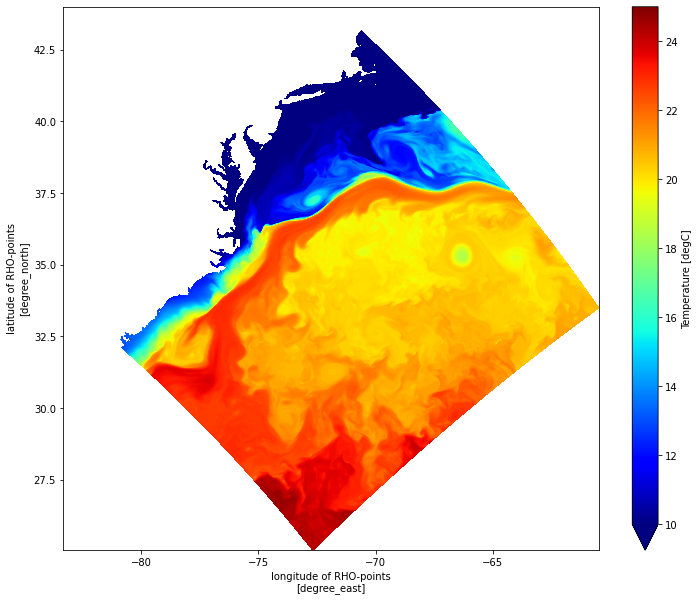

In [21]:

ds.temp.where(ds.mask_rho==1).isel(time=0, s_rho=-1,xi_rho=slice(0,-1) ).plot(x='lon_rho', y='lat_rho',\
                            vmin=10., vmax=25., cmap='jet', figsize=(12,10))

#####

---

## Interpolation to the intermediate grid point : Kinetic energy
\begin{equation}
\frac{1}{2}(u^2 + v^2)
\end{equation}

CPU times: user 2.71 s, sys: 431 ms, total: 3.14 s
Wall time: 7.53 s


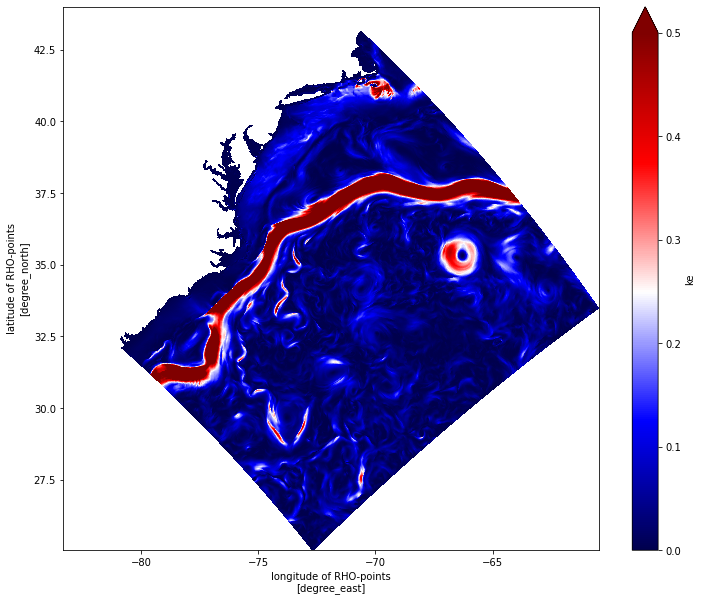

In [22]:
%%time
ds['ke'] = 0.5 * (grid.interp(ds.u**2,'x') + grid.interp(ds.v**2,'y'))

ds.ke.where(ds.mask_rho==1).isel(s_rho=-1).plot(x='lon_rho', y='lat_rho',\
                                                cmap='seismic', vmin=0, vmax=0.5, figsize=(12,10))

---

## Derivatives : relative vorticity
\begin{equation}
\xi = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
\end{equation}

CPU times: user 2.74 s, sys: 307 ms, total: 3.04 s
Wall time: 5.14 s


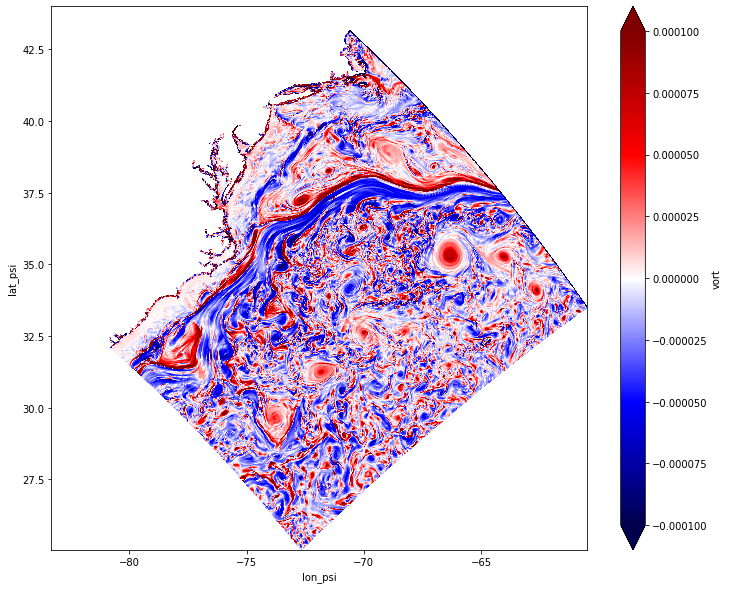

In [23]:
%%time
ds['vort'] = (-grid.derivative(ds.u, 'y') + grid.derivative(ds.v, 'x'))

ds.vort.where(ds.mask_psi==1).isel(s_rho=-1).plot(x='lon_psi', y='lat_psi',\
                                                  vmin=-1e-4, vmax=1e-4, cmap='seismic', figsize=(12,10))

---

## Transforming coordinates :   


peak memory: 1322.73 MiB, increment: 10.91 MiB
peak memory: 1378.39 MiB, increment: 55.66 MiB
CPU times: user 4.82 s, sys: 1.3 s, total: 6.12 s
Wall time: 30.2 s


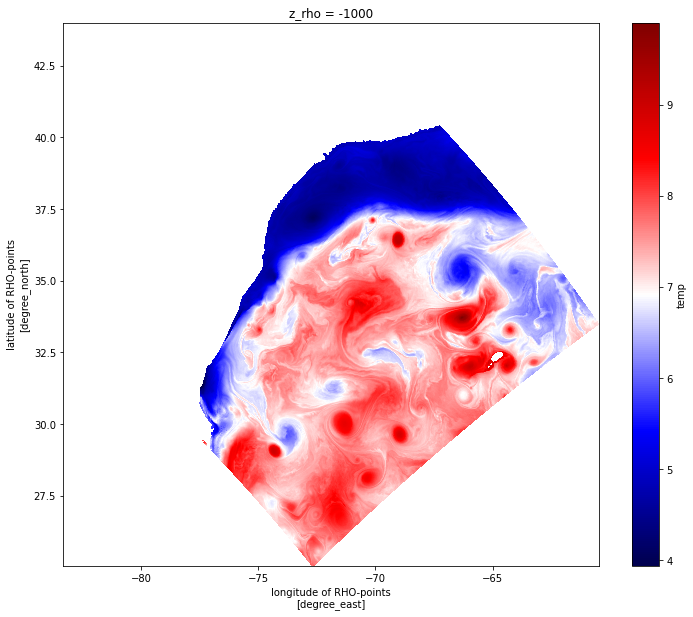

In [24]:
%%time
# Interpolate rho at depth=-100m
%memit var = grid.transform(ds.temp, 'z', [-1000], target_data=ds.z_rho).compute()
%memit var.plot(x='lon_rho', y='lat_rho', cmap='seismic', figsize=(12,10))

## Plot vertical section

peak memory: 1322.85 MiB, increment: 0.00 MiB
peak memory: 1322.93 MiB, increment: 0.08 MiB
CPU times: user 1.8 s, sys: 473 ms, total: 2.27 s
Wall time: 7.05 s


/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


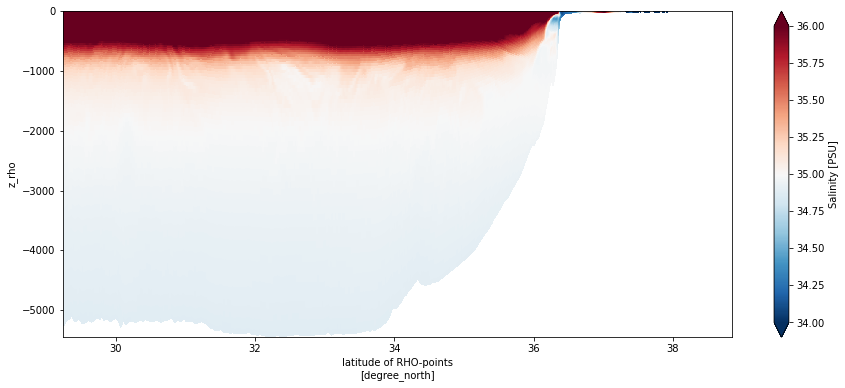

In [25]:
%%time

%memit section = ds.salt.isel(xi_rho=np.int(ds.h.shape[0]/2),  time=0)
%memit section.plot(x='lat_rho', y='z_rho', vmin=34., vmax=36., figsize=(15, 6), cmap = 'RdBu_r')


peak memory: 1323.09 MiB, increment: 0.02 MiB
peak memory: 1323.09 MiB, increment: 0.00 MiB
CPU times: user 2.08 s, sys: 471 ms, total: 2.55 s
Wall time: 8.33 s


/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


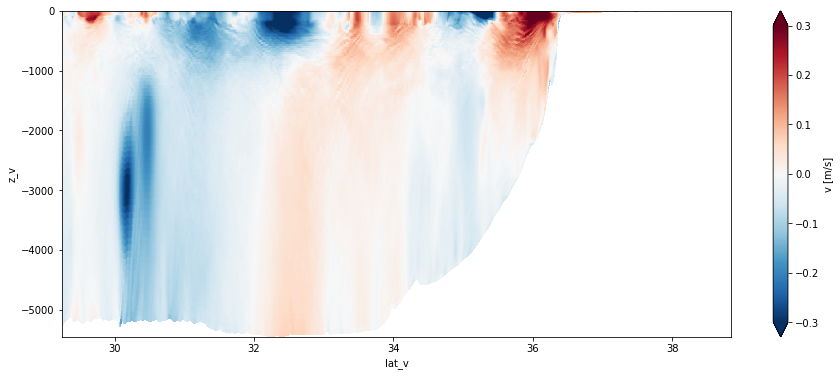

In [26]:
%%time

%memit section = ds.v.isel(xi_rho=np.int(ds.h.shape[0]/2),  time=0)
%memit section.plot(x='lat_v', y='z_v', vmin=-0.3, vmax=0.3,  figsize=(15, 6), cmap = 'RdBu_r')


## Compute density

In [38]:
#######################################################

def rho1_eos(Tt,Ts,z_r,g,rho0):
'''
compute density from equation of state
'''

    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;

    sqrtTs=Ts ** 0.5;
    
    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))\
    +Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))\
    +sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))\
    +Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    
    K2=E00+Tt*(E01+Tt*E02)\
    +Ts*(E10+Tt*(E11+Tt*E12));
    
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))\
    +Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))\
    +sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);

    #######################################################

    return rho1



#######################################################


def rho_eos(Tt,Ts,z_r,g,rho0):
'''
compute in-situ density (rho) from equation of state
'''

    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;

    sqrtTs=Ts ** 0.5;
    
    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))\
    +Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))\
    +sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))\
    +Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    
    K2=E00+Tt*(E01+Tt*E02)\
    +Ts*(E10+Tt*(E11+Tt*E12));
    
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))\
    +Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))\
    +sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);

    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));

    #######################################################

    return rho


In [39]:
ds['g'] = 9.81

ds['rho1'] = rho1_eos(ds.temp,ds.salt,ds.z_rho,ds.g,ds.rho0)
ds['rho'] = rho_eos(ds.temp,ds.salt,ds.z_rho,ds.g,ds.rho0)


peak memory: 1348.86 MiB, increment: 0.03 MiB
peak memory: 1349.20 MiB, increment: 0.34 MiB
CPU times: user 2.11 s, sys: 462 ms, total: 2.57 s
Wall time: 7.87 s


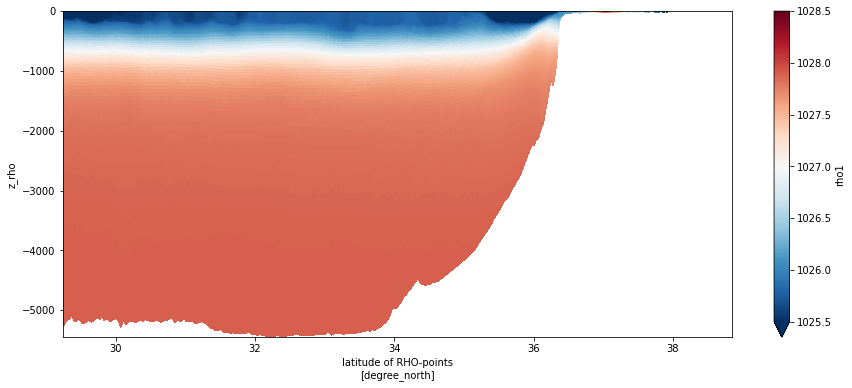

In [47]:
%%time

%memit section = ds.rho1.isel(xi_rho=np.int(ds.h.shape[0]/2),  time=0)
%memit section.plot(x='lat_rho', y='z_rho', vmin=1025.5, vmax=1028.5, figsize=(15, 6), cmap = 'RdBu_r')
